In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate, signal

from tqdm.notebook import tqdm, trange
from tqdm.keras import TqdmCallback

import pathlib, sys, os
from os import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_recall_curve, classification_report, confusion_matrix,accuracy_score, 
                             precision_score, recall_score, f1_score,roc_auc_score, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


plt.style.use('classic')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

# Functions

In [27]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_results(y_true, y_pred, history = None, class_th = 0.5):
    """
    a function to plot model performance
    
    y_true  : ground truth labels
    y_pred  : predictions made by the model
    history : training and validation loss and accuracy (optional)
    class_th: threshold for classification    
    """
    
    # calculate prediction classes
    y_pred_class = y_pred > class_th
    
    # calculate precision and recall curve
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)

    # print classification report
    print(classification_report(y_true, y_pred_class))

    if history:
        fig, axes = plt.subplots(figsize = (12,7), ncols = 2, nrows = 2)
    else:
        fig, axes = plt.subplots(figsize = (12,4), ncols = 2)

    # plot confusion matrix
    ax = axes.flatten()[0]
    sns.heatmap(confusion_matrix(y_true, y_pred_class), annot = True, ax = ax,cmap='Blues', fmt='g')
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Predicted')

    # plot individual cases: true labels vs. given probability
    ax = axes.flatten()[1]
    df = pd.DataFrame({'True': y_true.flatten(), 'Pred': y_pred.flatten()})
    sns.stripplot(data = df, x = 'True', y = 'Pred', ax = ax)
    ax.hlines(class_th, -0.25,1.25, color = 'green', ls = '--')
    ax.set_ylabel('p(X=OLD)')
    ax.set_xlabel('Age')

    # plot train and validation loss and accuracy
    if history:
        accuracy = history.history["accuracy"]
        val_accuracy = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(accuracy) + 1)

        ax = axes.flatten()[2]
        ax.plot(epochs, accuracy, color = 'red', marker = 'o', alpha = 0.7, label="Training accuracy")
        ax.plot(epochs, val_accuracy, color = 'green', marker = 'o', label="Validation accuracy", alpha = 0.8)
        
        w = int((len(val_accuracy) // 2.5) // 2 * 2 + 1) # savgol_gulary filter window size
        smooth_val_accuracy = signal.savgol_filter(val_accuracy, w, 3)
        ax.plot(epochs, smooth_val_accuracy, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_accuracy, color = 'green', ls = '--', lw = '2')

        
        ax.set_title("Accuracy")

        ax = axes.flatten()[3]
        ax.plot(epochs, loss, color = 'red', alpha = 0.7, marker = 'o', label="Training")
        ax.plot(epochs, val_loss, color = 'green', marker = 'o', label="Validation", alpha = 0.8)
        
        smooth_val_loss = signal.savgol_filter(val_loss, w, 3)
        ax.plot(epochs, smooth_val_loss, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_loss, color = 'green', ls = '--', lw = '2')
        
        ax.set_title("Loss")
        ax.legend(loc = 'best')

    plt.tight_layout()
    plt.show()

def fetch(subjects, freq = 128, n_seconds = 3, train = False):
    """
    A function to read subjects accelerometer data.
    
    params: 
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False
    
    """
    
    output = pd.DataFrame() # output dataframe
        
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s+'//d.csv')
            data.columns = ['time','x','y','z','t']
        except:
            print(s,':\t',sys.exc_info()[0])
            continue


        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

#         # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()
    
#         filtering the data with butterworth filter. this didn't improve the results, so we skip it
#         sos = signal.butter(1, 10, 'low', output = 'sos', fs = fs) 
    
        data.set_index('time', inplace = True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is 
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)

        for c in data.columns[:-1]:
            y = data[c]          
#             y = signal.sosfilt(sos, y) # apply the butterworth filter
            f = interpolate.interp1d(x, y)
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1,-1))
            temp['Subject'] = int(s.split('//')[1])
            temp['Axis'] = c
            temp = temp[['Subject','Axis'] + list(range(freq * n_seconds))]
            output = output.append(temp, ignore_index = True)

    # attach demographics to accelerometer re-calculated data
    age = pd.read_excel('ages.xlsx') #.iloc[:,:-1]
    age.columns = ['Subject', 'Age', 'Gender']
    output = output.merge(age, how = 'left', on = 'Subject')
    output = output[['Subject','Age','Gender','Axis'] + list(range(freq * n_seconds))]
    return output

# Reading subjects age data

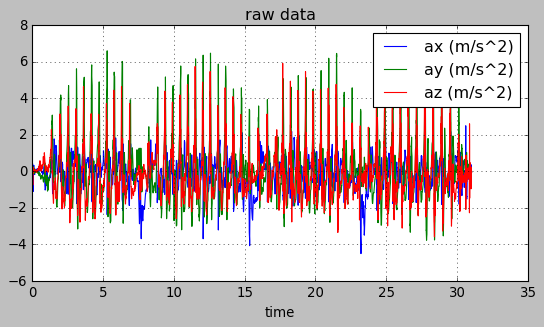

In [28]:
subjects = pd.read_excel('ages.xlsx')[['Subject #','Age']]
folders = ['data//'+str(c) for c in subjects['Subject #'].values]

# example for raw data.
d = pd.read_csv(folders[30]+'//d.csv').set_index('time')
d.iloc[:,:3].plot()
plt.title('raw data');

In [29]:
folders

['data//1',
 'data//4',
 'data//5',
 'data//6',
 'data//7',
 'data//8',
 'data//10',
 'data//11',
 'data//12',
 'data//14',
 'data//15',
 'data//16',
 'data//17',
 'data//18',
 'data//19',
 'data//20',
 'data//21',
 'data//22',
 'data//23',
 'data//26',
 'data//27',
 'data//28',
 'data//29',
 'data//30',
 'data//31',
 'data//32',
 'data//33',
 'data//34',
 'data//35',
 'data//36',
 'data//37',
 'data//38',
 'data//39',
 'data//40',
 'data//41',
 'data//42',
 'data//43',
 'data//44',
 'data//45',
 'data//46',
 'data//47',
 'data//48',
 'data//49',
 'data//50',
 'data//51',
 'data//52',
 'data//53',
 'data//54',
 'data//55',
 'data//56',
 'data//57',
 'data//58',
 'data//59',
 'data//60',
 'data//61',
 'data//62',
 'data//63',
 'data//64',
 'data//65',
 'data//66',
 'data//67',
 'data//68',
 'data//69',
 'data//70',
 'data//71',
 'data//72',
 'data//73',
 'data//74',
 'data//75',
 'data//76',
 'data//77',
 'data//78',
 'data//79',
 'data//80',
 'data//81',
 'data//82',
 'data//83',
 'dat

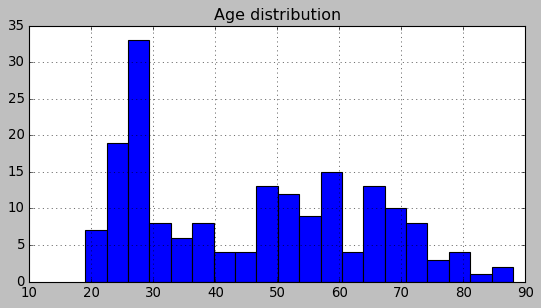

In [30]:
subjects['Age'].hist(bins = 20)
plt.title('Age distribution');

In [31]:
# call the fetch function to read data
n_seconds = 8
newfreq = 100

data = fetch(folders, freq = newfreq, n_seconds = n_seconds)



  0%|          | 0/183 [00:00<?, ?it/s]

Too short dataset data//21: 10.707
data//48 :	 <class 'FileNotFoundError'>
data//57 :	 <class 'FileNotFoundError'>
data//58 :	 <class 'FileNotFoundError'>
data//62 :	 <class 'FileNotFoundError'>
data//75 :	 <class 'FileNotFoundError'>
data//79 :	 <class 'FileNotFoundError'>
Too short dataset data//82: 9.07261
Too short dataset data//83: 10.657971
Too short dataset data//84: 8.884408
Too short dataset data//85: 9.720683
Too short dataset data//86: 8.819899
Too short dataset data//87: 10.611134
Too short dataset data//88: 9.484914
data//93 :	 <class 'FileNotFoundError'>
Too short dataset data//102: 11.751869916915894
data//152 :	 <class 'FileNotFoundError'>
Too short dataset data//156: 10.566492


,Subject,Age,Gender,Axis,0,1,2,3,4,5,...,790,791,792,793,794,795,796,797,798,799
0,1,72,F,x,0.9540,0.883205,0.838525,0.838458,0.994138,1.113119,...,-0.002373,-0.231614,-0.300374,-0.281514,-0.299953,-0.320457,-0.485880,-0.561977,-0.590070,-0.5870
1,1,72,F,y,-0.1344,-0.337565,-0.469122,-0.628107,-0.828843,-0.982325,...,0.031852,0.622066,1.112103,1.372877,2.066751,2.637787,2.932121,3.021183,3.225616,3.4002
2,1,72,F,z,1.4765,1.820913,1.731057,1.417543,0.707848,0.236582,...,-1.007719,-0.998149,-0.999774,-0.981441,-0.787484,-0.229081,0.427798,0.874973,1.426328,1.5613
3,4,25,M,x,1.7283,2.408333,1.801672,1.424076,1.867200,2.228065,...,0.431744,0.452029,0.150833,-0.093082,-0.236363,-0.254131,-0.189778,-0.122631,-0.222577,-0.5448
4,4,25,M,y,0.3930,0.117411,0.086469,0.171711,0.654188,0.951126,...,-1.121614,-1.069980,-0.767051,-0.660388,-0.583282,-0.604478,-0.603157,-0.579823,-0.592750,-0.7078
5,4,25,M,z,0.0770,-0.051855,-1.097439,-1.681627,-2.330505,-2.710259,...,0.521537,0.474782,0.420832,0.474674,0.451097,0.389819,0.467700,0.465706,0.395433,0.1701
6,5,53,M,x,0.1621,0.254315,0.219703,0.164353,0.146443,0.129895,...,-0.571169,-0.009107,0.969319,2.287587,3.114419,3.142351,2.665213,2.296339,1.988694,0.9386
7,5,53,M,y,0.1767,0.171551,0.022431,-0.017297,-0.092391,-0.175380,...,4.087396,3.516318,3.135882,2.542666,1.697889,0.833044,-0.085539,-0.550132,-0.893724,-1.7540
8,5,53,M,z,-0.0695,0.206124,-0.274933,-0.236309,-0.163265,0.017776,...,-0.019673,-1.198943,-0.601820,-0.214363,-0.646287,-1.294784,-1.699049,-1.763292,-1.768046,-1.7789
9,6,49,M,x,-0.2471,0.458863,0.709884,0.685532,0.622276,0.560905,...,-0.686011,-0.756383,-0.749754,-0.743125,-0.736496,-0.729868,0.123265,0.172863,0.402479,0.5356


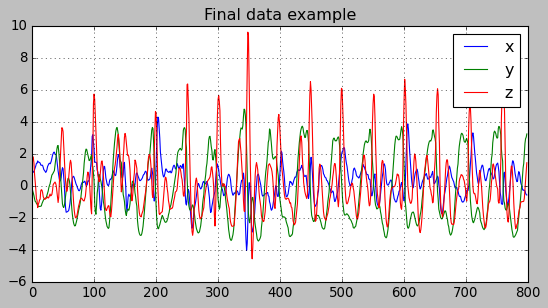

In [32]:
# we get three lines per subject - representing the accelerometer's x, y and z components.
display(data.head(12))

# and we can see an example
data.loc[:2,np.arange(data.columns[-1])].T.plot()
plt.legend(labels = ['x','y','z'])
plt.title('Final data example');



  0%|          | 0/165 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(165, 800, 49, 3)
True label: 48.5%


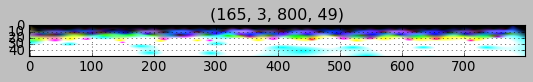

In [33]:
def moving_average(x, w = 20):
    return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype = np.float64), 
                  (0,w), mode = 'constant')


# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)

ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1,1)

X = data[np.arange(n)].values.reshape(-1, 3, n)
X = np.transpose(X, [0,2,1])

Xt = np.zeros((X.shape[0], 3, X.shape[1], 49))

# filtering using low-pass butterworth

for x in trange(X.shape[0]):
    for i in range(3):
        X[x][:,i] = signal.detrend(X[x][:,i])
        X[x][:,i] = moving_average(X[x][:,i])
        Xt[x][i] = np.abs(signal.cwt(X[x][:,i], wavelet = signal.morlet2, widths = np.arange(1, 50)).T)
    
X = Xt


plt.imshow(X[0].T)
plt.title(str(X.shape))

X = X.transpose(0,2,3,1)
print(X.shape)

# prepare the data set
batch_size = 32

# defining classes as categorical
print(f"True label: {y.mean() * 100:.1f}%")
        

In [43]:
from tensorflow.keras import layers, models, Input, regularizers
import tensorflow as tf

def init_model(input_shape=(3, 800, 49)):
    """
    Initialize a CNN model to handle 4D input with added regularization and dropout for better generalization.
    """
    inputs = Input(shape=input_shape)

    # Apply convolutional layers across the timesteps and CWT features
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      data_format='channels_first',
                      kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2), data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      data_format='channels_first',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2), data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(),
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
model = init_model()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3, 800, 49)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 800, 49)       896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 400, 24)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Ba  (None, 32, 400, 24)       96        
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 32, 400, 24)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 400, 24)       1849

In [46]:
from tensorflow.keras import layers, models, Input

def init_model(input_shape=(800, 49, 3)):
    inputs = Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Now output will be (400, 24, 32)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Now output will be (200, 12, 64)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Initialize the model
model = init_model()
model.summary()
# Adjust the reshaping of Xt when preparing datasets, assuming Xt originally has shape (samples, channels, height, width)
Xt = np.transpose(Xt, (0, 2, 3, 1))  # Reorder from (samples, channels, height, width) to (samples, height, width, channels)

# Now, Xt should have the shape (samples, height, width, channels), which is (samples, 800, 49, 3) in your case


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 800, 49, 3)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 800, 49, 32)       896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 400, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 400, 24, 64)       18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 200, 12, 64)       0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 153600)            0   

In [47]:
import tensorflow as tf
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import numpy as np

# Assuming Xt and y have already been defined and preprocessed correctly
epochs = 5
batch_size = 32
k = 5  # Number of folds

# Data and model configuration
k_fold = KFold(n_splits=k, shuffle=True)

# Dictionaries to store results
results = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

for fold, (train_idx, test_idx) in enumerate(k_fold.split(Xt)):
    print(f"Training on fold {fold+1}...")

    # Creating datasets for training and testing
    train_dataset = tf.data.Dataset.from_tensor_slices((Xt[train_idx], y[train_idx]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((Xt[test_idx], y[test_idx])).batch(batch_size)

    # Initialize the model
    model = init_model(input_shape=(3, 800, 49))

    # Callbacks
    model_path = f"model_fold_{fold}.h5"
    checkpoint = keras_callbacks.ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor="val_loss"
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=epochs // 5,  # Adjusted patience to a reasonable fraction of epochs
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        verbose=0,
        validation_data=test_dataset,
        callbacks=[checkpoint, early_stopping]
    )

    # Load the best model and evaluate on the test set
    model.load_weights(model_path)
    predictions = model.predict(test_dataset)
    predictions_binary = (predictions > 0.5).astype(int)

    # Calculating metrics
    y_true = np.array([y for _, y in test_dataset.unbatch()])
    results['k-Fold'].append(fold)
    results['Precision'].append(precision_score(y_true, predictions_binary))
    results['Recall'].append(recall_score(y_true, predictions_binary))
    results['AUROC'].append(roc_auc_score(y_true, predictions))

    precision, recall, _ = precision_recall_curve(y_true, predictions.ravel())
    results['AUCPR'].append(auc(recall, precision))

# Output final results
avg_precision = np.mean(results['Precision'])
avg_recall = np.mean(results['Recall'])
avg_auroc = np.mean(results['AUROC'])
avg_aucpr = np.mean(results['AUCPR'])

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")
print(f"Average AUCPR: {avg_aucpr:.4f}")


Training on fold 1...


ValueError: Exception encountered when calling layer "max_pooling2d_17" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_17/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,400,64].

Call arguments received by layer "max_pooling2d_17" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 400, 64), dtype=float32)

# building the model

In [35]:
def init_model():
    inputs = keras.Input(shape = X.shape[1:])    
    x = inputs[:,:,0]
    y = inputs[:,:,1]
    z = inputs[:,:,2]
    
    x = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(x)        
    x = layers.Dense(4, activation = "relu")(x)
    
    y = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(y)
    y = layers.Dense(4, activation = "relu")(y)
    
    z = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(z)
    z = layers.Dense(4, activation = "relu")(z)
    
    outputs = layers.Flatten()(tf.concat([x,y,z], axis = 1))
    outputs = layers.Dense(1, activation = 'sigmoid')(outputs)
    
    
    model = keras.Model(inputs = inputs, outputs = outputs)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=100,
        decay_rate=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

       
    # since our data in now always precisely balanced, we are more intreasted in precision and recall than accuracy.
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizer,
                  metrics = [tf.keras.metrics.AUC(curve = 'ROC')]
#                   metrics=["accuracy",
#                            tf.keras.metrics.Precision(),
#                            tf.keras.metrics.Recall()],
                  )
    
    return model


model = init_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 800, 49, 3)]         0         []                            
                                                                                                  
 tf.__operators__.getitem_7  (None, 800, 3)               0         ['input_3[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.__operators__.getitem_8  (None, 800, 3)               0         ['input_3[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                            

In [24]:
inputs = keras.Input(shape = X.shape[1:])    
x = inputs[:,:,0]
y = inputs[:,:,1]
z = inputs[:,:,2]

x = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(x)
x = layers.MaxPool1D(pool_size = 3)(x)        
x = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = layers.MaxPool1D(pool_size = 3)(x)        
x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = layers.MaxPool1D(pool_size = 3)(x)        
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(x)        
x = layers.Dense(4, activation = "relu")(x)

y = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(y)
y = layers.MaxPool1D(pool_size = 3)(y) 
y = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(y)
y = layers.MaxPool1D(pool_size = 3)(y) 
y = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(y)
y = layers.MaxPool1D(pool_size = 3)(y) 
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(y)
y = layers.Dense(4, activation = "relu")(y)

z = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(z)
z = layers.MaxPool1D(pool_size = 3)(z) 
z = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(z)
z = layers.MaxPool1D(pool_size = 3)(z) 
z = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(z)
z = layers.MaxPool1D(pool_size = 3)(z) 
z = layers.BatchNormalization()(z)
z = layers.Dropout(0.5)(z)
z = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(z)
z = layers.Dense(4, activation = "relu")(z)

outputs = layers.Flatten()(tf.concat([x,y,z], axis = 1))
outputs = layers.Dense(1, activation = 'sigmoid')(outputs)
model = keras.Model(inputs = inputs, outputs = outputs)

In [36]:
print(inputs.shape)
print(outputs.shape)

(None, 800, 49, 3)
(None, 1)


## training the model

In [25]:
# model arguments
epochs = 5

history = []
datasets = []
df = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

from sklearn.model_selection import KFold, cross_val_score
k = 5
k_fold = KFold(n_splits=k, shuffle=True)
k_fold = k_fold.split(X)

for j, (train, test) in enumerate(k_fold):
    train_dataset = tf.data.Dataset.from_tensor_slices((X[train], y[train]))
    train_dataset = train_dataset.shuffle(buffer_size = batch_size, reshuffle_each_iteration=True).batch(batch_size = batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((X[test], y[test])).batch(batch_size = batch_size)
    
   
    model = init_model()
    
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="cnn.keras",
        save_best_only=True,
        monitor="val_loss"),
    
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     min_delta=0,
                                     patience=epochs // 25,
                                     restore_best_weights = True),
                                     
    TqdmCallback(verbose=0),]

    
    history.append(model.fit(train_dataset,
                    epochs = epochs,
                    verbose = 0,
                    validation_data = test_dataset,
                    callbacks = callbacks,
                    shuffle = True
                   ))
    
    # evaluate
    y_pred = model.predict(test_dataset) > 0.5
    datasets.append(test_dataset)
    df['k-Fold'].append(j)
    df['Precision'].append(precision_score(y[test], y_pred))
    df['Recall'].append(recall_score(y[test], y_pred))    
    df['AUROC'].append(roc_auc_score(y[test], y_pred))
    
    precision, recall, _ = precision_recall_curve(y[test], y_pred)
    df['AUCPR'].append(auc(recall, precision))



TypeError: Exception encountered when calling layer "tf.__operators__.getitem_6" (type SlicingOpLambda).

Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,  12,  14,  15,
        16,  17,  18,  19,  21,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  34,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,  48,
        49,  50,  51,  52,  53,  55,  56,  57,  59,  60,  61,  62,  63,
        65,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,  78,  79,
        80,  81,  82,  85,  86,  87,  88,  89,  90,  92,  93,  94,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 127, 128, 129, 132, 133, 134, 137, 139, 140, 141, 145,
       146, 147, 148, 150, 151, 152, 154, 155, 157, 159, 160, 161, 162,
       163, 164])

Call arguments received by layer "tf.__operators__.getitem_6" (type SlicingOpLambda):
  • tensor=tf.Tensor(shape=(None, 29, 4), dtype=float32)
  • slice_spec=array([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,  12,  14,  15,
        16,  17,  18,  19,  21,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  34,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,  48,
        49,  50,  51,  52,  53,  55,  56,  57,  59,  60,  61,  62,  63,
        65,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,  78,  79,
        80,  81,  82,  85,  86,  87,  88,  89,  90,  92,  93,  94,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 127, 128, 129, 132, 133, 134, 137, 139, 140, 141, 145,
       146, 147, 148, 150, 151, 152, 154, 155, 157, 159, 160, 161, 162,
       163, 164])
  • var=None

In [ ]:
df_f = pd.DataFrame(df)
df_f = df_f.melt(id_vars = 'k-Fold')
sns.barplot(data = df_f, x = 'k-Fold', y = 'value', hue = 'variable')
plt.hlines(0.5, plt.xlim()[0], plt.xlim()[1], ls = '--', lw = 2, color = 'black')
plt.legend(ncol = 4, title = None, bbox_to_anchor = (1,-.05))



In [ ]:
for i in range (k):

    y_pred = history[i].model.predict(next(iter(datasets[i]))[0])
    y_test = np.array(next(iter(datasets[i]))[1])
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    aucpr = auc(recall, precision)
    
    print(f'Model # {i}, AUROC: {roc_auc_score(y_test, y_pred):.3f}, AUCPR: {aucpr:.3f}')
    print('-'*40)
    plot_results(y_test, y_pred)

    

In [ ]:
import matplotlib.pyplot as plt

# Your data
model_result = [
    ['basic_model_rmsprop', '0.6514285802841187'],
    ['basic_model_adam', '0.7428571581840515'],
    ['augm_model', 0.729],
    ['augm_model', 0.774],
    ['regular_model', '0.8371428847312927'],
    ['VGG16_model', 0.802]
]

# Separate data into model names and values
model_names = []
values = []

for entry in model_result:
    model_names.append(entry[0])
    values.append(float(entry[1]))  # Convert values to float

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values with lines representing the rise
ax.plot(model_names, values, marker='o', linestyle='-')

# Set labels and title
ax.set_xlabel('Model Names')
ax.set_ylabel('Values')
ax.set_title('Rise in Values for Different Models')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
